In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from altair import Chart, X, Y, Scale
dirs = ['./output/2017-09-12/']
# os.listdir('output/2017-09-12')

In [4]:
dfs = []
for dir in dirs:
    dfs += [pd.read_csv(dir + filename)
           for filename in os.listdir(dir)]
df = pd.concat(dfs)
df['epoch_time'] = df['train_time'] / df['epoch']
#test_df = df[df['mode'] == 'test']
print(df['num_workers'].unique())
# df
#df[df.epoch == df.epoch.max()]
# df.head()

[1 2 3 4 8]


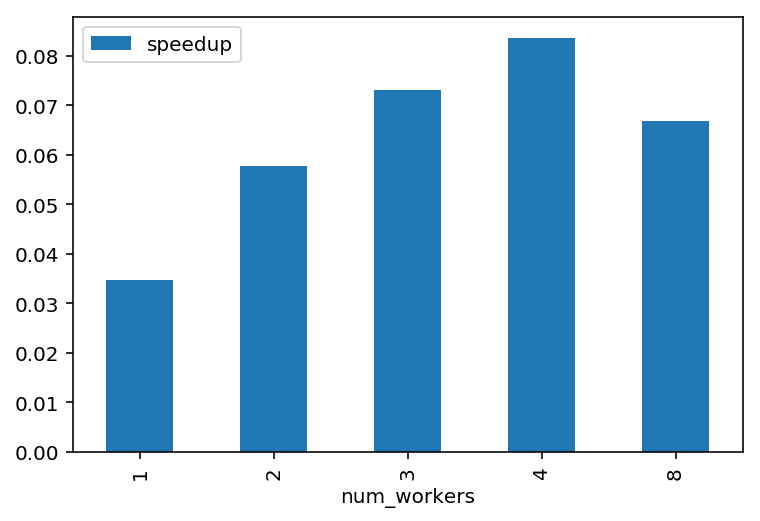

In [5]:
show = df.pivot_table(index='num_workers', values='epoch_time')
show['speedup'] = 1 / show['epoch_time']
show.plot.bar(y='speedup')
plt.show()

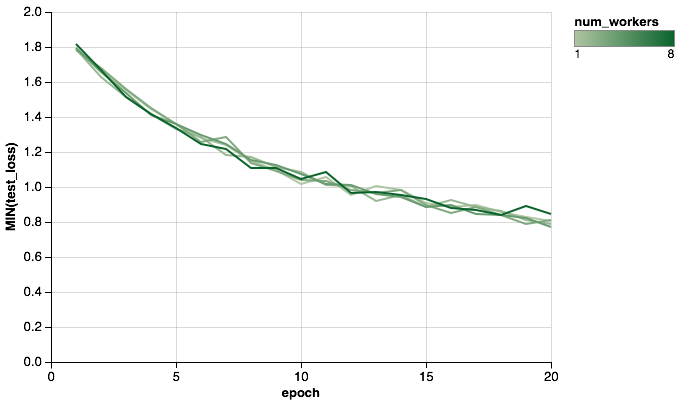

In [7]:
Chart(df).mark_line().encode(
    x=X('epoch', scale=Scale(type='linear')),
    y=Y('min(test_loss)'),#, scale=Scale(domain=(None, None), clamp=True)),
    color='num_workers')

In [8]:
# Chart(df).mark_line().encode(
#     x=X('epoch', scale=Scale(type='linear')),
#     y=Y('mean(test_acc)', scale=Scale(domain=(0.00, 1), clamp=True)),
#     color='num_workers')

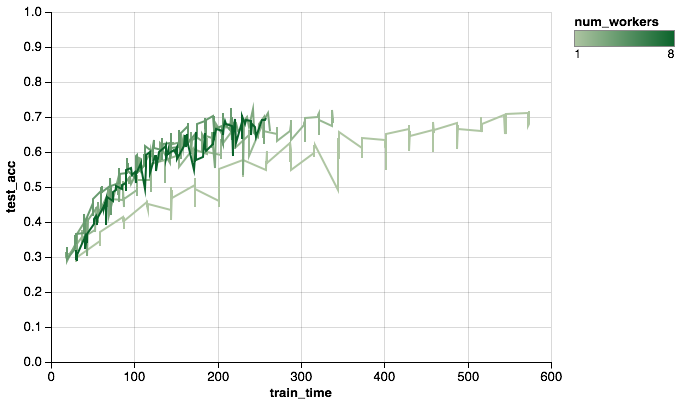

In [9]:
Chart(df).mark_line().encode(
    x=X('train_time', scale=Scale(type='linear', zero=False)),
    y=Y('test_acc', scale=Scale(domain=(0.00, 1), clamp=True)),
    color='num_workers')

In [13]:
def time_to_accuracy(df, accuracy, key='test_acc', time='train_time'):
    df = df[df[key] >= accuracy]
    if len(df) == 0:
        return {k: None for k in [key, time]}
    i = np.argmin(np.abs(df[key] - accuracy))
    return {k: df.T[i][k] for k in [key, time]}

times = []
accuracy = 0.650
# accuracy = 0.85
for one_df in dfs:
    summary = {}
    for key in ['seed', 'num_workers']:
        assert len(one_df[key].unique()) == 1
        summary[key] = one_df[key].unique()[0]
        
    times += [{**time_to_accuracy(one_df, accuracy, key='test_loss'),
               **summary}]


times = pd.DataFrame(times)
# times.head()
show = times.pivot_table(index='num_workers', values='train_time')
show['num_workers'] = show.index
show['speedup'] = show.T[1]['train_time'] / show['train_time']
show

,train_time,num_workers,speedup
num_workers,,,
1,539.928521,1,1.000000
2,332.459090,2,1.624045
3,230.388360,3,2.343558
4,211.018478,4,2.558679
8,230.909156,8,2.338272


In [14]:
# times['speedup'] = times[times.num_workers == 1]['time'].values[0] / times['time'] 
# from altair import X, Y, Scale
# Chart(times).mark_circle().encode(
#     x=X('train_time', scale=Scale(zero=False)),
#     y=Y('test_acc'   , scale=Scale(zero=False)),
#     color='num_workers', shape='seed')

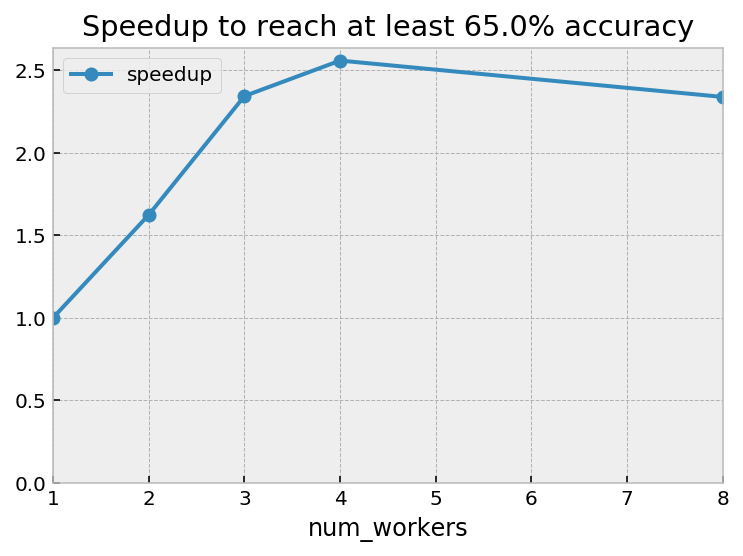

In [15]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
show.plot(x='num_workers', y='speedup', title=f'Speedup to reach at least {100*accuracy}% accuracy',
          style='o-', ylim=(0, None))
# plt.ylim(0, 1.2)
plt.show()